In [12]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn 
import torch.nn.functional as F 
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import TensorDataset, DataLoader
from torchmetrics.classification import ConfusionMatrix,F1Score
import unicodedata
import spacy
import re
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/natedrake7/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/natedrake7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Pre-Processing

In [22]:
#Read csv files
train_set = pd.read_csv('./Data/train_set.csv')
valid_set = pd.read_csv('./Data/valid_set.csv')
test_set = pd.read_csv('./Data/test_set.csv')



#Drop Party and New ID columns since we dont need them
labels_to_drop = ['Party','New_ID']
train_set = train_set.drop(columns=labels_to_drop)
valid_set = valid_set.drop(columns=labels_to_drop)
test_set = test_set.drop(columns=['Party'])

#Make all text lowercase
train_set['Text'] = train_set['Text'].str.lower()
valid_set['Text'] = valid_set['Text'].str.lower()
test_set['Text'] = test_set['Text'].str.lower()

train_set['Text'] = train_set['Text'].apply(lambda x: re.sub(r'#', '', x))
valid_set['Text'] = valid_set['Text'].apply(lambda x: re.sub(r'#', '', x))
test_set['Text'] = test_set['Text'].apply(lambda x: re.sub(r'#', '', x))

#Remove accents from all text
def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    return ''.join([c for c in nfkd_form if not unicodedata.combining(c)])

train_set['Text'] = train_set['Text'].apply(remove_accents)
valid_set['Text'] = valid_set['Text'].apply(remove_accents)
test_set['Text'] = test_set['Text'].apply(remove_accents)

#Remove stopwords and replace them with a single space
stop = stopwords.words('greek')
pat = r'\b(?:{})\b'.format('|'.join(stop))

train_set['Text'] = train_set['Text'].str.replace(pat,'',regex=True)
valid_set['Text'] = valid_set['Text'].str.replace(pat,'',regex=True)
test_set['Text'] = test_set['Text'].str.replace(pat,'',regex=True)

#Remove multiple white spaces and replace them with a single space
train_set['Text'] = train_set['Text'].str.replace(r'\s+',' ',regex=True) #remove multiple whitespaces
valid_set['Text'] = valid_set['Text'].str.replace(r'\s+',' ',regex=True) #remove multiple whitespaces
test_set['Text'] = test_set['Text'].str.replace(r'\s+',' ',regex=True) #remove multiple whitespaces

#Remove links and replace them with a single space
train_set['Text'] = train_set['Text'].apply(lambda x: re.sub('https?://[A-Za-z0-9./]+','',x)) #remove links
valid_set['Text'] = valid_set['Text'].apply(lambda x: re.sub('https?://[A-Za-z0-9./]+','',x)) #remove links
test_set['Text'] = test_set['Text'].apply(lambda x: re.sub('https?://[A-Za-z0-9./]+','',x)) #remove links

#Replace non greek words with single whitespace
train_set['Text'] = train_set['Text'].apply(lambda x: re.sub(r'[^α-ωΑ-Ω0-9\s]', ' ', x, flags=re.UNICODE))      
valid_set['Text'] = valid_set['Text'].apply(lambda x: re.sub(r'[^α-ωΑ-Ω0-9\s]', ' ', x, flags=re.UNICODE))      
test_set['Text'] = test_set['Text'].apply(lambda x: re.sub(r'[^α-ωΑ-Ω0-9\s]', ' ', x, flags=re.UNICODE))

#Find retweets and replace them withn single whitespace
train_set['Text'] = train_set['Text'].apply(lambda x: re.sub(r'^RT[\s]+', '', x))
valid_set['Text'] = valid_set['Text'].apply(lambda x: re.sub(r'^RT[\s]+', '', x))
test_set['Text'] = test_set['Text'].apply(lambda x: re.sub(r'^RT[\s]+', '', x))

#Load lemmatizer
nlp = spacy.load("el_core_news_sm")

def lemmatize_text(text):
    doc = nlp(text)
    lemmatized_text = " ".join([token.lemma_ for token in doc])
    return lemmatized_text

#Lemmatize text to replace words with their dictionary value
train_set['Text'] = train_set['Text'].apply(lemmatize_text)
valid_set['Text'] = valid_set['Text'].apply(lemmatize_text)
test_set['Text'] = test_set['Text'].apply(lemmatize_text)

Save Pre-Processed Data

In [23]:
train_set.to_csv('processed_df',index=False)
valid_set.to_csv('processed_valid',index=False)
test_set.to_csv('processed_test',index=False)

Load Pre-Processed Data

In [24]:
train_set = pd.read_csv('processed_df')

test_set = pd.read_csv('processed_test')

valid_set = pd.read_csv('processed_valid')

In [3]:
#Read csv files
train_data = pd.read_csv('./Data/train_set.csv')
test_data = pd.read_csv('./Data/test_set.csv')

#Create Dataframes
train_set = pd.DataFrame(train_data)
test_set = pd.DataFrame(test_data)

Tokenize Text and create W2V Model

In [25]:
train_set['Tokenized_Text'] = train_set['Text'].apply(lambda x: word_tokenize(x))

# Create Word2Vec models
model = Word2Vec(sentences=train_set['Tokenized_Text'], vector_size=250,window=5,min_count=2,sg = 1,hs = 0,negative = 10)

model.train(train_set['Tokenized_Text'], total_examples= len(train_set['Text']), epochs=20)

# Save the model
model.save("./Data/word2vec.model")

Load self-trained Word2Vec Model

In [26]:
word2vec_model = Word2Vec.load('./Data/word2vec.model')

Load pre-trained Word2Vec Model

In [ ]:
word2vec_model = Word2Vec.load('./Models/word2vec.model')

In [57]:
print(word2vec_model.wv.most_similar('τσιπρας'))
valid_set['Tokenized_Text'] = valid_set['Text'].apply(lambda x: word_tokenize(x))

[('αλαζονικος', 0.5175630450248718), ('κρασιος', 0.46218010783195496), ('εψαχνας', 0.459391713142395), ('βανδαλος', 0.4532196819782257), ('αποχαιρετηζω', 0.4530605673789978), ('δειχνη', 0.4384254217147827), ('κολλημενος', 0.43832316994667053), ('διστασε', 0.43790578842163086), ('μοιραιο', 0.4370492994785309), ('μαχες', 0.43514540791511536)]


Encode Labels

In [41]:
encoder  = LabelEncoder() #initialize label encoder so we can set integer values to the label unique values

X_train_labels = encoder.fit_transform(train_set['Sentiment'])
X_valid_labels = encoder.fit_transform(valid_set['Sentiment'])

print(encoder.classes_)
print(encoder.transform(encoder.classes_))
labels = {0 : 'NEGATIVE',1 : 'NEUTRAL',2 : 'POSITIVE'}

['NEGATIVE' 'NEUTRAL' 'POSITIVE']
[0 1 2]


In [33]:
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0
    for word in tokens:
        try:
            vec += word2vec_model.wv[word].reshape((1, size))
            count += 1.
        except KeyError:  # handling the case where the token is not in vocabulary
            continue
    if count != 0:
        vec /= count
    return vec

In [38]:
wordvec_train_arrays = np.zeros((len(train_set['Tokenized_Text']), 250)) 
wordvec_valid_arrays = np.zeros((len(valid_set['Tokenized_Text']), 250)) 

for i in range(len(train_set['Tokenized_Text'])):
    wordvec_train_arrays[i,:] = word_vector(train_set['Tokenized_Text'][i], 250)
for i in range(len(valid_set['Tokenized_Text'])):
   wordvec_valid_arrays[i,:] = word_vector(valid_set['Tokenized_Text'][i], 250)


(5232, 250)

In [46]:
wordvec_train_arrays.shape

(36630, 250)

Create Tensorflow tensors

In [80]:
batch_size = 2

#Train set
X_train_tensor = torch.tensor(wordvec_train_arrays,dtype=torch.float)
Labels_train_tensor = torch.tensor(X_train_labels,dtype=torch.long) #create a torch tensor for the labels from the numpy array
Dataset = TensorDataset(X_train_tensor,Labels_train_tensor) #Create a dataset
Train_set = DataLoader(Dataset,batch_size=batch_size,shuffle=True) #Create the train set


#Val set
X_val_tensor = torch.tensor(wordvec_valid_arrays,dtype=torch.float)
Labels_val_tensor = torch.tensor(X_valid_labels,dtype=torch.long) #create a torch tensor for the labels from the numpy array
Dataset = TensorDataset(X_val_tensor,Labels_val_tensor) #Create a dataset
Validation_set = DataLoader(Dataset,batch_size=batch_size,shuffle=True) #Create the validation set

Set Gpu Or Cpu

In [48]:
if torch.cuda.is_available(): #if nvidia gpu is available
   device="cuda" #set devide to cuda since GPUs are much faster at deep learning
else: 
   device="cpu" #else set CPU
print("Device =",device)

Device = cuda


FeedForward Neural Network

In [81]:
class FeedForwardNeuralNetwork(nn.Module):
    def __init__(self, dropout_rate= 0.5): #initialize feedforward network
        super(FeedForwardNeuralNetwork, self).__init__()
        self.linear1 = nn.Linear(250, 128) # You can also try include activation functions to check how your model will behave
        self.dropout1 = nn.Dropout(dropout_rate) #set for each fully connected layer the dropout rate
        self.linear2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(dropout_rate) #set for each fully connected layer the dropout rate
        self.linear3 = nn.Linear(64, 32)
        self.dropout3 = nn.Dropout(dropout_rate) #set for each fully connected layer the dropout rate
        self.linear4 = nn.Linear(32, 3)
        
    def forward(self, x):
        h1 = F.relu(self.linear1(x))
        h2 = F.relu(self.linear2(h1))
        h3 = F.relu(self.linear3(h2))
        out = self.linear4(h3)
        return out
    
model = FeedForwardNeuralNetwork(dropout_rate = 0.5).to(device) #Create a feedforward network instance

Train Function

In [85]:
def Train(dataLoader,model,loss_fn,optimizer):
    losses = []
    size = len(dataLoader.dataset) #Get the size of the dataset
    f1 = 0 #declare f1 score to 0
    f1_score = F1Score(task='multiclass',num_classes=3,average='weighted').to(device)
    
    for batch, (X,y) in enumerate(dataLoader): #iterate all the dataset

        X = X.to(device) #Load variables to GPU
        y = y.to(device) #Load variables to GPU
        
        pred = model(X) #predict the label

        loss = loss_fn(pred,y) #find the loss between the prediction and the true label
        losses.append(loss.item())

        #BackPropagation
        optimizer.zero_grad() #reset all the gradients

        loss.backward()
        
        optimizer.step() #perform a step

        f1 += f1_score(pred.argmax(1),y) #calculate the f1 score

    f1 /= size #find the average f1 score    
    return f1, sum(losses)/len(losses)

Validation Function

In [51]:
def Validation(dataloader,model,loss_fn):
    size = len(dataloader.dataset) #get the size of the dataset
    f1 = 0 #declare f1 score to 0
    f1_score = F1Score(task='multiclass',num_classes=3,average='weighted').to(device)
    losses = []

    with torch.no_grad(): #disable gradient caclulation since we are validating not training
        for X,y in dataloader:

            X = X.to(device)#Load to GPU
            y = y.to(device) #Load variables to GPU
        
            pred = model(X) #predict the label
            
            loss = loss_fn(pred,y) #find the loss between the prediction and the true label
            losses.append(loss.item())
            f1 += f1_score(pred.argmax(1),y) #calculate the f1 score
    f1 /= size #find the average f1 score
    return f1, (sum(losses)/len(losses))

Test Function

In [52]:
def Test(dataloader,model,loss_fn):
    size = len(dataloader.dataset) #get the size of the dataset
    test_loss,correct,f1 = 0,0,0 #declare variables
    f1_score = F1Score(task='multiclass',num_classes=3,average='weighted').to(device) 

    with torch.no_grad(): #disable gradient caclulation since we are testing not training
        for X,y in dataloader:

            X = X.to(device) #Load to GPU
            y = y.to(device) #Load to GPU

            pred = model(X) #predict the label

            test_loss += loss_fn(pred,y).item() #find the loss_fn
            
            correct += (pred.argmax(1) == y).type(torch.float).sum().item() #find the accuracy
            f1 += f1_score(pred.argmax(1),y) #find the f1 score
    
    test_loss /= size #compute the average loss
    correct /= size #average accuracy
    f1 /= size #average f1 score
    confmat = ConfusionMatrix('multiclass',num_classes=3).to(device)
    confusion_matrix = confmat(pred,y) #find the confusion matrix
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f},Avg F1-Score: {f1:>8f}\n") #print statistics
    print(f"Confusion Matrix \n: {confusion_matrix}\n") #print confusion matrix

Learning Curve Function

In [64]:
def plot_loss_learning_curve(train_losses, val_losses):
    epochs = range(1, len(train_losses) + 1)

    plt.plot(epochs,train_losses, label='Training Loss')
    plt.plot(epochs,val_losses, label='Validation Loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.legend()

    plt.title('Learning Curve')
    
    plt.show()

def plot_f1_learning_curve(train_f1, val_f1):
    epochs = range(1, len(train_f1) + 1)

    plt.plot(epochs,train_f1, label='Training F1')
    plt.plot(epochs,val_f1, label='Validation F1')

    plt.xlabel('Epoch')
    plt.ylabel('F1-Score')

    plt.legend()

    plt.title('Learning Curve')
    
    plt.show()

Experimenting

Adjusting learning rate of group 0 to 1.0000e-04.
Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 1
-------------------------------
Adjusting learning rate of group 0 to 9.9975e-05.
Adjusting learning rate of group 0 to 8.9978e-05.
Epoch 2
-------------------------------
Adjusting learning rate of group 0 to 8.9911e-05.
Adjusting learning rate of group 0 to 8.0920e-05.
Epoch 3
-------------------------------
Adjusting learning rate of group 0 to 8.0820e-05.
Adjusting learning rate of group 0 to 7.2738e-05.
Epoch 4
-------------------------------
Adjusting learning rate of group 0 to 7.2613e-05.
Adjusting learning rate of group 0 to 6.5351e-05.
Epoch 5
-------------------------------
Adjusting learning rate of group 0 to 6.5206e-05.
Adjusting learning rate of group 0 to 5.8686e-05.
Epoch 6
-------------------------------
Adjusting learning rate of group 0 to 5.8526e-05.
Adjusting learning rate of group 0 to 5.2673e-05.
Epoch 7
-------------------------------
Adjusting learning r

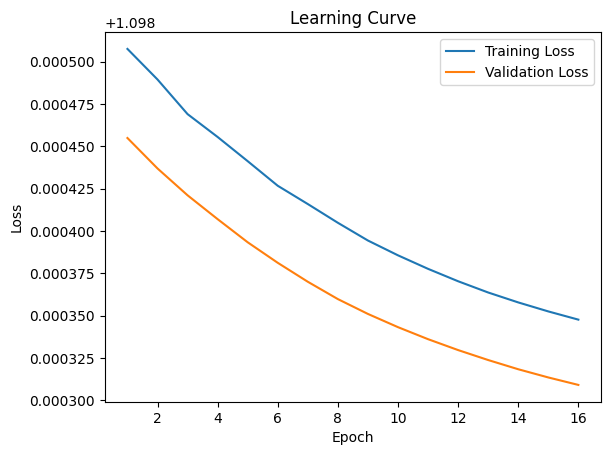

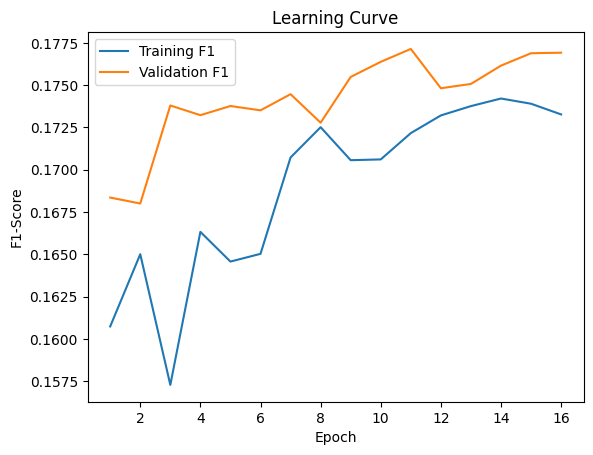

Test Error: 
 Accuracy: 35.7%, Avg loss: 0.549154,Avg F1-Score: 0.177975

Confusion Matrix 
: tensor([[0, 0, 0],
        [2, 0, 0],
        [0, 0, 0]], device='cuda:0')



In [86]:
loss_fn = nn.CrossEntropyLoss()
best_f1 = 0 #initialize variables
learning_rate = 1e-4
patience = 0
epochs_count = 30
patience_tol = 5
f1_train_scores = []
f1_val_scores = []
train_losses = []
val_losses = []

#optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate,weight_decay=1e-7) #initialize optimizer ,weight_decay=1e-7

optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate,weight_decay=1e-7) #initialize optimizer
scheduler1 = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,verbose=True,T_max=100) #initialize first scheduler
scheduler2 = torch.optim.lr_scheduler.ExponentialLR(optimizer,gamma=0.9,verbose=True) #and second scheduler
scheduler = torch.optim.lr_scheduler.ChainedScheduler([scheduler1,scheduler2])

for t in range(epochs_count): #iterate over the number of epochs
    print(f"Epoch {t+1}\n-------------------------------")
    torch.cuda.synchronize()

    f1_train,train_loss = Train(Train_set,model,loss_fn,optimizer) #train the convo network

    f1_train_scores.append(f1_train.cpu())
    train_losses.append(train_loss)
    f1_val,val_loss = Validation(Validation_set,model,loss_fn) #find the current f1 score

    f1_val_scores.append(f1_val.cpu())
    val_losses.append(val_loss)

    scheduler.step()

    if f1_val > best_f1: #if it the best one yet
        best_f1 = f1_val #set it as the best one
        best_model = model #this is the best model yet
        patience = 0
    else:
        patience+=1 #else increment patience
    if patience == patience_tol: #if we have iterated over a number of epochs and still the model we found is the best one
        break #break from the iteration

print(f"Best Model computed by finding the model with the highest f1 score on the validation set: {best_f1:>8f}\n")
plot_loss_learning_curve(train_losses=train_losses,val_losses=val_losses)
plot_f1_learning_curve(train_f1=f1_train_scores,val_f1=f1_val_scores)
Test(Validation_set,best_model,loss_fn) #print the best model found

Final Training-Validation

Adjusting learning rate of group 0 to 1.0000e-04.
Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 1
-------------------------------
loss: 1.111701  [    0/25641]
loss: 1.106695  [ 1600/25641]
loss: 1.106623  [ 3200/25641]
loss: 1.087057  [ 4800/25641]
loss: 1.160367  [ 6400/25641]
loss: 1.096786  [ 8000/25641]
loss: 1.121040  [ 9600/25641]
loss: 1.087074  [11200/25641]
loss: 1.101559  [12800/25641]
loss: 1.125561  [14400/25641]
loss: 1.068013  [16000/25641]
loss: 1.068239  [17600/25641]
loss: 1.082518  [19200/25641]
loss: 1.106146  [20800/25641]
loss: 1.101285  [22400/25641]
loss: 1.101339  [24000/25641]
loss: 1.110640  [25600/25641]
Adjusting learning rate of group 0 to 9.9975e-05.
Adjusting learning rate of group 0 to 8.9978e-05.
Epoch 2
-------------------------------
loss: 1.161860  [    0/25641]
loss: 1.115155  [ 1600/25641]
loss: 1.119795  [ 3200/25641]
loss: 1.110472  [ 4800/25641]
loss: 1.110489  [ 6400/25641]
loss: 1.151567  [ 8000/25641]
loss: 1.055507  [ 9600/25641]


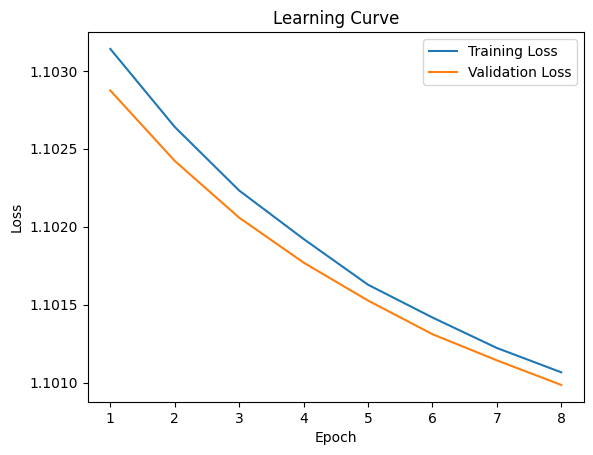

Test Error: 
 Accuracy: 33.3%, Avg loss: 0.068831,Avg F1-Score: 0.011132

Confusion Matrix 
: tensor([[0, 0, 3],
        [0, 0, 8],
        [0, 0, 2]], device='cuda:0')



In [15]:
loss_fn = nn.CrossEntropyLoss()
best_f1 = 0 #initialize variables
learning_rate = 1e-4
patience = 0
epochs_count = 30
patience_tol = 5
train_losses = []
val_losses = []

#optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate,weight_decay=1e-7) #initialize optimizer ,weight_decay=1e-7

optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate,weight_decay=1e-7) #initialize optimizer
scheduler1 = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,verbose=True,T_max=100) #initialize first scheduler
scheduler2 = torch.optim.lr_scheduler.ExponentialLR(optimizer,gamma=0.9,verbose=True) #and second scheduler

scheduler = torch.optim.lr_scheduler.ChainedScheduler([scheduler1,scheduler2])

for t in range(epochs_count): #iterate over the number of epochs
    print(f"Epoch {t+1}\n-------------------------------")
    torch.cuda.synchronize()
    train_losses.append(Train(Train_set,model,loss_fn,optimizer)) #train the convo network
    f1,val_loss = Validation(Validation_set,model,loss_fn) #find the current f1 score

    scheduler.step()
    
    val_losses.append(val_loss)

    if f1 > best_f1: #if it the best one yet
        best_f1 = f1 #set it as the best one
        best_model = model #this is the best model yet
        patience = 0
    else:
        patience+=1 #else increment patience
    if patience == patience_tol: #if we have iterated over a number of epochs and still the model we found is the best one
        break #break from the iteration
print(f"Best Model computed by finding the model with the highest f1 score on the validation set: {best_f1:>8f}\n")
plot_learning_curve(train_losses=train_losses,val_losses=val_losses)
Test(Validation_set,best_model,loss_fn) #print the best model found

$
\begin{array}{|c|c|c|c|}
\hline
\text{Optimizer} & \text{Accuracy} & \text{F1-Score} & \text{Time}\\
\hline
\text{SGD} & \text{70.9\%} & \text{0.012845} & \text{25.1s}\\
\hline
\text{Adadelta} & \text{72.6\%} & \text{0.013035} & \text{25.1s}\\
\hline
\text{Adagrad} & \text{75.7\%} & \text{0.013490} & \text{30.1s}\\
\hline
\text{Adam} & \text{41.1\%} & \text{0.008715} & \text{27.5s}\\
\hline
\text{AdamW} & \text{72.2\%} & \text{0.012843} & \text{26.7s}\\
\hline
\text{Adamax} & \text{72.0\%} & \text{0.012983} & \text{36.8s}\\
\hline
\text{ASGD} & \text{71.9\%} & \text{0.012984} & \text{25.9s}\\
\hline
\text{NAdam} & \text{71.4\%} & \text{0.012894} & \text{28.0s}\\
\hline
\text{RAdam} & \text{68.9\%} & \text{0.012647} & \text{28.3s}\\
\hline
\text{RMSprop} & \text{61.3\%} & \text{0.010841} & \text{25.0s}\\
\hline
\text{Rprop} & \text{63.2\%} & \text{0.012063} & \text{53.1s}\\
\hline
\end{array}
$
